In this experiment, we do the following:
* Transfer learning using the pre-trained model _Yamnet_ as feature extractor.
* Hyperparameter tuning for the upper layers.
* Re-train model for accuracy.
* Re-train model with only the most frequent classes.

In [ ]:
%pip install -U -q tensorflow tensorflow_datasets
#apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
%pip install -U -q keras-tuner

In [5]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import pathlib
import os
from os.path import isfile, join, splitext

import tensorflow as tf
from tensorflow import keras
import tensorflow_io as tfio
import tensorflow_hub as tfhub
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Sequential
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
from pydub import AudioSegment
import librosa
import soundfile as sf

SAMPLING_RATE = 16000
EPOCHS = 50
BATCH_SIZE = 128
SHUFFLE_SEED = 42
TUNING_DIRECTORY = "model7_tuning_dir"
PROJECT_NAME = "model7_tuning"
MODEL_NAME = "MODEL7"

# Set the seed value for experiment reproducibility.
tf.random.set_seed(SHUFFLE_SEED)
np.random.seed(SHUFFLE_SEED)

## Part 1: Hyperparameter Tuning

### 1.1 Prepare dataset

In this part we are going to prepare the dataset for hyperparameter tuning. Here we implement the _transfer learning_ process: we are going to use the **Yamnet** pre-trained model that will serve as the feature extractor at the lowest layer. Yamnet's output will be used by the layers above it, which are the layers that will be tuned.

In [6]:
yamnet_model = tf.saved_model.load('./yamnet_1')

The dataset is from **audio10.csv** which contains classes that have at least 10 samples. The audio samples are stored in **data/downsampled** in the form of WAV files.

In [25]:
dataframe = pd.read_csv(os.getcwd() + "/data/audio10.csv", on_bad_lines = 'skip' , delimiter= ';')
# dataframe = dataframe[(dataframe['native_langs'] == 'english') | (dataframe['native_langs'] == 'spanish')]

class_names = dataframe['class_labels'].unique()
# lang_idxs = range(len(class_names))
# class_dict = dict(zip(class_names, lang_idxs))
print(f"Success loading data! There are {len(class_names)} classes.")

# Rewrite file_name to contain file paths
dataframe['file_name'] = dataframe.apply(
    lambda row: os.path.join(os.getcwd(), 'data/downsampled', row['file_name'] + '.wav'), 
    axis=1
)

Success loading data! There are 53 classes.


The functions below perform preprocessing operations on the dataset, such as decoding audio and transforming Pandas dataframe to TensorFlow dataset. Here is also where Yamnet is used to perform feature extraction on audio files.

In [8]:
def load_16k_audio_wav(filename):
    # Read file content
    file_content = tf.io.read_file(filename)

    # Decode audio wave
    audio_wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    audio_wav = tf.squeeze(audio_wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Resample to 16k
    audio_wav = tfio.audio.resample(audio_wav, rate_in=sample_rate, rate_out=16000)
    return audio_wav


def filepath_to_embeddings(filename, label):
    # Load 16k audio wave
    audio_wav = load_16k_audio_wav(filename)

    # Get audio embeddings & scores.
    # The embeddings are the audio features extracted using transfer learning
    # while scores will be used to identify time slots that are not speech
    # which will then be gathered into a specific new category 'other'
    scores, embeddings, _ = yamnet_model(audio_wav)

    # Number of embeddings in order to know how many times to repeat the label
    embeddings_num = tf.shape(embeddings)[0]
    labels = tf.repeat(label, embeddings_num)

    # Change labels for time-slots that are not speech into a new category 'other'
    # labels = tf.where(tf.argmax(scores, axis=1) == 0, label, len(class_names) - 1)

    # Using one-hot in order to use AUC
    return (embeddings, tf.one_hot(labels, len(class_names)))


def dataframe_to_dataset(df_x, df_y, batch_size=64):
    # Convert the labels into numbers -- no longer necessary since we're targetting the class_labels column
    # dataframe['native_langs'] = dataframe.apply(
    #     lambda row: class_dict[row['native_langs']],
    #     axis=1
    # )

    dataset = tf.data.Dataset.from_tensor_slices((df_x, df_y))

    dataset = dataset.map(
        lambda x, y: filepath_to_embeddings(x, y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    ).unbatch()

    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

For hyperparameter tuning, we split the data 80-20 for training and validation.

In [9]:
X = dataframe.iloc[:, :-1]
y = dataframe['class_labels']
sss = StratifiedShuffleSplit(test_size=0.2, random_state=SHUFFLE_SEED)
for train_index, test_val_index in sss.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[test_val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_val_index]

print(f'''
Splitting success!
X: {len(X)}, y: {len(y)}
X_train: {len(X_train)}, y_train: {len(y_train)}
X_val: {len(X_val)}, y_val: {len(y_val)}
''')

train_ds = dataframe_to_dataset(X_train['file_name'], y_train)
validation_ds = dataframe_to_dataset(X_val['file_name'], y_val)

print('Conversion to dataset success!')


Splitting success!
X: 2546, y: 2546
X_train: 2036, y_train: 2036
X_val: 510, y_val: 510

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-01-20 01:43:05.222260: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


Conversion to dataset success!


### 1.2 Build the model for hyperparameter tuning

In [10]:
def build_and_compile_model(hp):
    inputs = keras.layers.Input(shape=(1024), name="embedding")

    # Tune the number of units in the first Dense layer. Choose an optimal value between 32-512
    hp_units = hp.Int('dense_layer_1', min_value=32, max_value=512, step=32)
    x = keras.layers.Dense(units=hp_units, activation="relu", name="dense_1")(inputs)
    x = keras.layers.Dropout(0.15, name="dropout_1")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(0.25, name="dropout_3")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(0.2, name="dropout_4")(x)

    outputs = keras.layers.Dense(len(class_names), activation="softmax", name="ouput")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="accent_recognition")

    # Tune the learning rate for the optimizer. Choose an optimal value from 0.001, 0.0001, or 1.9644e-5
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1.9644e-5])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )
    # model.summary()

    return model

In [13]:
# Instantiate the hyperparameter tuner. 
# Set overwrite=False to continue the search from last session, overwrite=True to start new search everytime.

tuner = kt.Hyperband(build_and_compile_model,
                    objective='val_accuracy',
                    max_epochs=20,
                    factor=3,
                    hyperband_iterations=10,
                    directory=TUNING_DIRECTORY,
                    project_name=PROJECT_NAME,
                    overwrite=False)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_ds, 
            epochs=20, 
            validation_data=validation_ds, 
            callbacks=[stop_early],
            verbose=2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layers is {best_hps.get('dense_layer_1')}. 
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 58 Complete [00h 02m 42s]
val_accuracy: 0.21187497675418854

Best val_accuracy So Far: 0.21187497675418854
Total elapsed time: 01h 15m 47s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layers is 448. 
The optimal learning rate for the optimizer is 1.9644e-05.



## Part 2: Model Training & Evaluation

In this part we are going to train the model using the best hyperparameters from the previous part. Then, we are going to evaluate and plot the model's performance.

First, we load the dataset for training, validation, and test purposes. We are using the same data source from audio10.csv but instead of making 80-20 split, we are going to make 80-10-10 split.

### 2.1 Prepare dataset

In [26]:
df = pd.read_csv(os.getcwd() + "/data/audio10.csv", on_bad_lines = 'skip' , delimiter= ';')
# dataframe = dataframe[(dataframe['native_langs'] == 'english') | (dataframe['native_langs'] == 'spanish')]

class_names_full = df['class_labels'].unique()
# lang_idxs = range(len(class_names))
# class_dict = dict(zip(class_names, lang_idxs))
print(f"Success loading dataset! There are {len(class_names_full)} classes.")

# Rewrite file_name to contain file paths
df['file_name'] = df.apply(
    lambda row: os.path.join(os.getcwd(), 'data/downsampled', row['file_name'] + '.wav'), 
    axis=1
)

Success loading dataset! There are 53 classes.


These are the same data preprocessing operations, including the use of Yamnet model for feature extraction.

In [18]:
def load_16k_audio_wav(filename):
    # Read file content
    file_content = tf.io.read_file(filename)

    # Decode audio wave
    audio_wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    audio_wav = tf.squeeze(audio_wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Resample to 16k
    audio_wav = tfio.audio.resample(audio_wav, rate_in=sample_rate, rate_out=16000)
    return audio_wav


def filepath_to_embeddings(filename, label):
    # Load 16k audio wave
    audio_wav = load_16k_audio_wav(filename)

    # Get audio embeddings & scores.
    # The embeddings are the audio features extracted using transfer learning
    # while scores will be used to identify time slots that are not speech
    # which will then be gathered into a specific new category 'other'
    scores, embeddings, _ = yamnet_model(audio_wav)

    # Number of embeddings in order to know how many times to repeat the label
    embeddings_num = tf.shape(embeddings)[0]
    labels = tf.repeat(label, embeddings_num)

    # Change labels for time-slots that are not speech into a new category 'other'
    # labels = tf.where(tf.argmax(scores, axis=1) == 0, label, len(class_names) - 1)

    # Using one-hot in order to use AUC
    return (embeddings, tf.one_hot(labels, len(class_names_full)))


def dataframe_to_dataset(df_x, df_y, batch_size=64):
    # Convert the labels into numbers -- no longer necessary since we're targetting the class_labels column
    # dataframe['native_langs'] = dataframe.apply(
    #     lambda row: class_dict[row['native_langs']],
    #     axis=1
    # )

    dataset = tf.data.Dataset.from_tensor_slices((df_x, df_y))

    dataset = dataset.map(
        lambda x, y: filepath_to_embeddings(x, y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    ).unbatch()

    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [19]:
X = df.iloc[:, :-1]
y = df['class_labels']
sss = StratifiedShuffleSplit(test_size=0.2, random_state=SHUFFLE_SEED)
for train_index, test_val_index in sss.split(X, y):
    X_train, X_test_val = X.iloc[train_index], X.iloc[test_val_index]
    y_train, y_test_val = y.iloc[train_index], y.iloc[test_val_index]

# additional split of test_val set to test and validation set
sss_val = StratifiedShuffleSplit(test_size=0.5, random_state=SHUFFLE_SEED)
for val_index, test_index in sss_val.split(X_test_val, y_test_val):
    X_val, X_test = X_test_val.iloc[val_index], X_test_val.iloc[test_index]
    y_val, y_test = y_test_val.iloc[val_index], y_test_val.iloc[test_index]

print(f'''
Splitting success!
X: {len(X)}, y: {len(y)}
X_train: {len(X_train)}, y_train: {len(y_train)}
X_val: {len(X_val)}, y_val: {len(y_val)}
X_test: {len(X_test)}, y_test: {len(y_test)}
''')

full_train_ds = dataframe_to_dataset(X_train['file_name'], y_train)
full_validation_ds = dataframe_to_dataset(X_val['file_name'], y_val)
full_test_ds = dataframe_to_dataset(X_test['file_name'], y_test)

print('Conversion to dataset success!')


Splitting success!
X: 2546, y: 2546
X_train: 2036, y_train: 2036
X_val: 255, y_val: 255
X_test: 255, y_test: 255

Conversion to dataset success!


### 2.2 Model training

#### Class weight calculation

Since the dataset is quite unbalanced, we wil use class_weight argument during training.

Getting the class weights is a little tricky because even though we know the number of audio files for each class, it does not represent the number of samples for that class since Yamnet transforms each audio file into multiple audio samples of 0.96 seconds each. So every audio file will be split into a number of samples that is proportional to its length.

Therefore, to get those weights, we have to calculate the number of samples for each class after preprocessing through Yamnet.

In [46]:
class_counts = tf.zeros(shape=(len(class_names_full),), dtype=tf.int32)

for x, y in iter(full_train_ds):
    class_counts = class_counts + tf.math.bincount(
        tf.cast(tf.math.argmax(y, axis=1), tf.int32), minlength=len(class_names_full)
    )

class_weight = {
    i: tf.math.reduce_sum(class_counts).numpy() / class_counts[i].numpy()
    for i in range(len(class_counts))
}

print(class_weight)

{0: 1.6871604973848393, 1: inf, 2: inf, 3: 214.45787545787545, 4: inf, 5: inf, 6: 81.48503827418233, 7: 10.525303370786517, 8: inf, 9: inf, 10: inf, 11: inf, 12: inf, 13: inf, 14: inf, 15: inf, 16: inf, 17: inf, 18: inf, 19: inf, 20: inf, 21: 110.98957345971564, 22: 205.06830122591944, 23: 127.4145810663765, 24: inf, 25: inf, 26: 69.12278630460449, 27: inf, 28: inf, 29: inf, 30: inf, 31: inf, 32: inf, 33: inf, 34: inf, 35: inf, 36: inf, 37: inf, 38: 178.22526636225265, 39: inf, 40: 52.041777777777774, 41: inf, 42: inf, 43: 4.757404623572909, 44: 144.0270602706027, 45: inf, 46: inf, 47: inf, 48: inf, 49: 58.226752859273994, 50: inf, 51: inf, 52: inf}


/var/folders/3p/fc9cp69s1lsfgnzqtqtddvz00000gn/T/ipykernel_41704/2769429807.py:9: RuntimeWarning: divide by zero encountered in int_scalars
  i: tf.math.reduce_sum(class_counts).numpy() / class_counts[i].numpy()


#### Train the model

We use Keras callbacks in order to:

- Stop whenever the validation AUC stops improving.
- Save the best model.
- Call TensorBoard in order to later view the training and validation logs.

In [47]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_auc", patience=10, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(MODEL_NAME + ".h5", monitor="val_auc", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(os.path.join(os.curdir, "logs", hypermodel.name))

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
hp = kt.HyperParameters()

history = hypermodel.fit(full_train_ds, 
                        validation_data=full_validation_ds,
                        epochs=EPOCHS,
                        class_weight=class_weight,
                        batch_size=hp.Choice(name='batch_size', values=[16, 32]),
                        callbacks=callbacks,
                        verbose=2)

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

# Save model
# hypermodel.save('tuned_model.h5')
# Load model
# model = keras.models.load_model('tuned_model.h5')

Epoch 1/50
1830/1830 - 29s - loss: 38.8980 - accuracy: 0.0362 - auc: 0.8747 - val_loss: 1.1206 - val_accuracy: 0.0257 - val_auc: 0.9127 - 29s/epoch - 16ms/step
Epoch 2/50
1830/1830 - 24s - loss: 32.3204 - accuracy: 0.0361 - auc: 0.8960 - val_loss: 1.0992 - val_accuracy: 0.0251 - val_auc: 0.9003 - 24s/epoch - 13ms/step
Epoch 3/50
1830/1830 - 25s - loss: 31.2512 - accuracy: 0.0331 - auc: 0.8942 - val_loss: 1.0925 - val_accuracy: 0.0222 - val_auc: 0.8956 - 25s/epoch - 13ms/step
Epoch 4/50
1830/1830 - 25s - loss: 30.6396 - accuracy: 0.0328 - auc: 0.8959 - val_loss: 1.0860 - val_accuracy: 0.0233 - val_auc: 0.8953 - 25s/epoch - 14ms/step
Epoch 5/50
1830/1830 - 24s - loss: 30.1477 - accuracy: 0.0338 - auc: 0.8981 - val_loss: 1.0899 - val_accuracy: 0.0245 - val_auc: 0.8908 - 24s/epoch - 13ms/step
Epoch 6/50
1830/1830 - 32s - loss: 29.7587 - accuracy: 0.0345 - auc: 0.9011 - val_loss: 1.0833 - val_accuracy: 0.0294 - val_auc: 0.8934 - 32s/epoch - 17ms/step
Epoch 7/50
1830/1830 - 38s - loss: 29.45

### 2.3 Model evaluation

In [48]:
train_loss, train_acc, train_auc = hypermodel.evaluate(full_train_ds)
valid_loss, valid_acc, valid_auc = hypermodel.evaluate(full_validation_ds)
test_loss, test_acc, test_auc = hypermodel.evaluate(full_test_ds)

231/231 [==============================] - 2s 5ms/step - loss: 1.0400 - accuracy: 0.0240 - auc: 0.9123


Let's try to compare our model's performance to Yamnet's using one of Yamnet metrics (d-prime). Yamnet achieved a d-prime value of 2.318. Let's check our model's performance.

In [49]:
# The following function calculates the d-prime score from the AUC
def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime


print(
    "train d-prime: {0:.3f}, validation d-prime: {1:.3f}".format(
        d_prime(train_auc), d_prime(valid_auc)
    )
)

train d-prime: 1.920, validation d-prime: 1.920


Plotting the accuracy and AUC results.

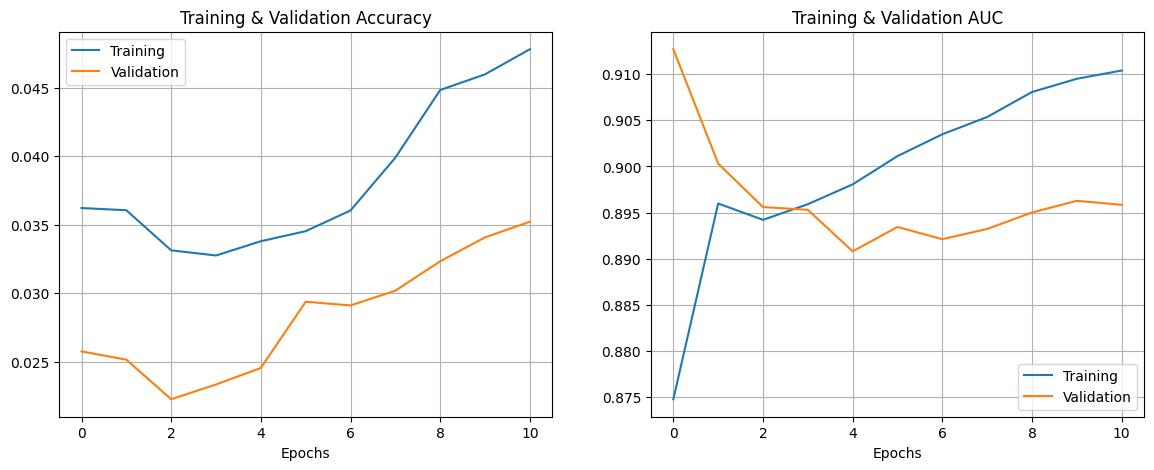

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(range(len(history.history["accuracy"])), history.history["accuracy"], label="Training")
axs[0].plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation")
axs[0].set_xlabel("Epochs")
axs[0].set_title("Training & Validation Accuracy")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(len(history.history["auc"])), history.history["auc"], label="Training")
axs[1].plot(range(len(history.history["val_auc"])), history.history["val_auc"], label="Validation")
axs[1].set_xlabel("Epochs")
axs[1].set_title("Training & Validation AUC")
axs[1].legend()
axs[1].grid(True)

plt.show()

### 2.4 Experiment: re-train model for accuracy

Since the previous model's accuracy is rather low (1.3% on the test set), we are going to experiment with re-training the model but with a different stopping criteria.

In [51]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(MODEL_NAME + "_accuracy.h5", monitor="val_accuracy", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(os.path.join(os.curdir, "logs", hypermodel.name))

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
hp = kt.HyperParameters()

history = hypermodel.fit(full_train_ds, 
                        validation_data=full_validation_ds,
                        epochs=EPOCHS,
                        class_weight=class_weight,
                        batch_size=hp.Choice(name='batch_size', values=[16, 32]),
                        callbacks=callbacks,
                        verbose=2)

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

# Save model
# hypermodel.save('tuned_model.h5')
# Load model
# model = keras.models.load_model('tuned_model.h5')

Epoch 1/50
1830/1830 - 27s - loss: 39.2138 - accuracy: 0.0660 - auc: 0.8908 - val_loss: 1.1682 - val_accuracy: 0.0171 - val_auc: 0.8788 - 27s/epoch - 15ms/step
Epoch 2/50
1830/1830 - 27s - loss: 32.4543 - accuracy: 0.0358 - auc: 0.8965 - val_loss: 1.1323 - val_accuracy: 0.0177 - val_auc: 0.8731 - 27s/epoch - 15ms/step
Epoch 3/50
1830/1830 - 23s - loss: 31.3209 - accuracy: 0.0370 - auc: 0.8975 - val_loss: 1.1178 - val_accuracy: 0.0199 - val_auc: 0.8767 - 23s/epoch - 12ms/step
Epoch 4/50
1830/1830 - 26s - loss: 30.6893 - accuracy: 0.0378 - auc: 0.9005 - val_loss: 1.1054 - val_accuracy: 0.0218 - val_auc: 0.8821 - 26s/epoch - 14ms/step
Epoch 5/50
1830/1830 - 25s - loss: 30.2024 - accuracy: 0.0412 - auc: 0.9045 - val_loss: 1.0922 - val_accuracy: 0.0243 - val_auc: 0.8890 - 25s/epoch - 14ms/step
Epoch 6/50
1830/1830 - 29s - loss: 29.7804 - accuracy: 0.0425 - auc: 0.9072 - val_loss: 1.0811 - val_accuracy: 0.0293 - val_auc: 0.8955 - 29s/epoch - 16ms/step
Epoch 7/50
1830/1830 - 27s - loss: 29.56

In [52]:
train_loss, train_acc, train_auc = hypermodel.evaluate(full_train_ds)
valid_loss, valid_acc, valid_auc = hypermodel.evaluate(full_validation_ds)
test_loss, test_acc, test_auc = hypermodel.evaluate(full_test_ds)

231/231 [==============================] - 1s 3ms/step - loss: 0.9740 - accuracy: 0.0558 - auc: 0.9106


In [53]:
# The following function calculates the d-prime score from the AUC
def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime


print(
    "train d-prime: {0:.3f}, validation d-prime: {1:.3f}".format(
        d_prime(train_auc), d_prime(valid_auc)
    )
)

train d-prime: 1.981, validation d-prime: 1.885


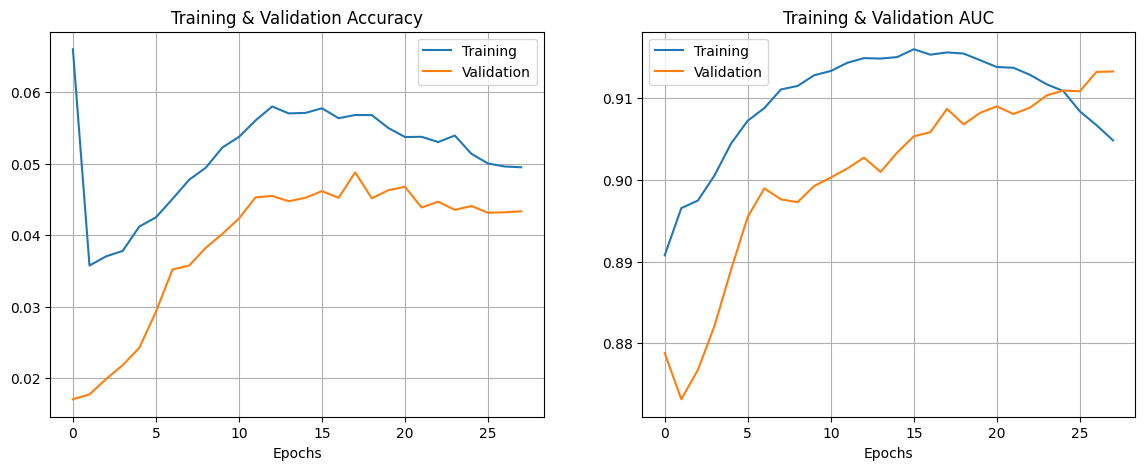

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(range(len(history.history["accuracy"])), history.history["accuracy"], label="Training")
axs[0].plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation")
axs[0].set_xlabel("Epochs")
axs[0].set_title("Training & Validation Accuracy")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(len(history.history["auc"])), history.history["auc"], label="Training")
axs[1].plot(range(len(history.history["val_auc"])), history.history["val_auc"], label="Validation")
axs[1].set_xlabel("Epochs")
axs[1].set_title("Training & Validation AUC")
axs[1].legend()
axs[1].grid(True)

plt.show()

### 2.5 Experiment: limiting to most frequent accents

In this section we limit our dataset to seven of the most frequent native languages.

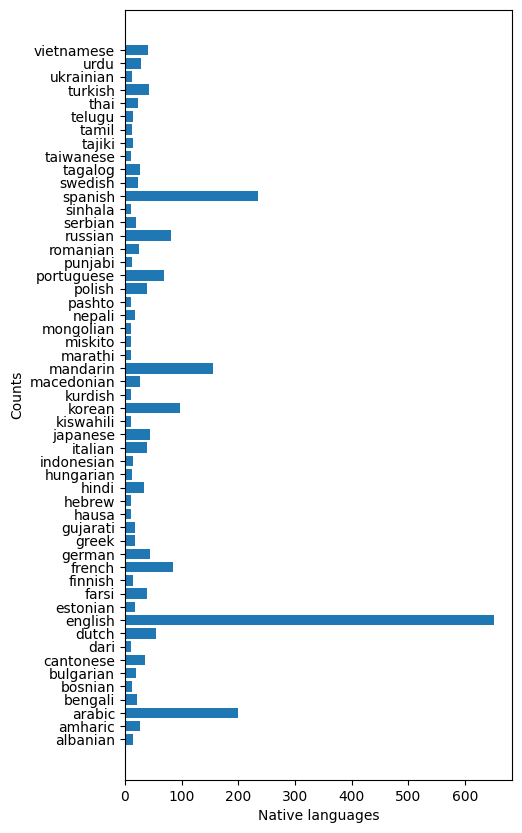

In [55]:
native_langs = df['native_langs'].unique()
native_langs_counts = [len(df[df['native_langs'] == lang]) for lang in native_langs]

fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(native_langs, native_langs_counts)
 
ax.set_xlabel("Native languages")
ax.set_ylabel("Counts")
plt.show()

In [56]:
dflim = pd.read_csv(os.getcwd() + "/data/audio10.csv", on_bad_lines = 'skip' , delimiter= ';')
dflim = dflim[(dflim['native_langs'] == 'english') | (dflim['native_langs'] == 'spanish') | (dflim['native_langs'] == 'mandarin') | (dflim['native_langs'] == 'arabic') | (dflim['native_langs'] == 'korean') | (dflim['native_langs'] == 'russian') | (dflim['native_langs'] == 'french')]

class_names_lim = dflim['class_labels'].unique()
print(f"Success loading dataset! There are {len(class_names_lim)} classes.")

# Rewrite file_name to contain file paths
dflim['file_name'] = dflim.apply(
    lambda row: os.path.join(os.getcwd(), 'data/downsampled', row['file_name'] + '.wav'), 
    axis=1
)

Success loading dataset! There are 7 classes.


In [57]:
def load_16k_audio_wav(filename):
    file_content = tf.io.read_file(filename)
    audio_wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    audio_wav = tf.squeeze(audio_wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    audio_wav = tfio.audio.resample(audio_wav, rate_in=sample_rate, rate_out=16000)
    return audio_wav


def filepath_to_embeddings(filename, label):
    audio_wav = load_16k_audio_wav(filename)
    scores, embeddings, _ = yamnet_model(audio_wav)
    embeddings_num = tf.shape(embeddings)[0]
    labels = tf.repeat(label, embeddings_num)
    return (embeddings, tf.one_hot(labels, len(class_names_lim)))


def dataframe_to_dataset(df_x, df_y, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((df_x, df_y))
    dataset = dataset.map(
        lambda x, y: filepath_to_embeddings(x, y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    ).unbatch()
    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [65]:
X = dflim.iloc[:, :-1]
y = dflim['class_labels']
sss = StratifiedShuffleSplit(test_size=0.2, random_state=SHUFFLE_SEED)
for train_index, test_val_index in sss.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[test_val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_val_index]

print(f'''
Splitting success!
X: {len(X)}, y: {len(y)}
X_train: {len(X_train)}, y_train: {len(y_train)}
X_val: {len(X_val)}, y_val: {len(y_val)}
''')

lim_train_ds = dataframe_to_dataset(X_train['file_name'], y_train)
lim_validation_ds = dataframe_to_dataset(X_val['file_name'], y_val)

print('Conversion to dataset success!')


Splitting success!
X: 1505, y: 1505
X_train: 1204, y_train: 1204
X_val: 301, y_val: 301

Conversion to dataset success!


Tune hyperparams.

In [69]:
def build_and_compile_model(hp):
    inputs = keras.layers.Input(shape=(1024), name="embedding")

    # Tune the number of units in the first Dense layer. Choose an optimal value between 32-512
    hp_units = hp.Int('dense_layer_1', min_value=32, max_value=512, step=32)
    x = keras.layers.Dense(units=hp_units, activation="relu", name="dense_1")(inputs)
    x = keras.layers.Dropout(0.15, name="dropout_1")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(0.25, name="dropout_3")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(0.2, name="dropout_4")(x)

    outputs = keras.layers.Dense(len(class_names_lim), activation="softmax", name="ouput")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="accent_recognition")

    # Tune the learning rate for the optimizer. Choose an optimal value from 0.001, 0.0001, or 1.9644e-5
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1.9644e-5])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )
    # model.summary()

    return model

In [70]:
tuner2 = kt.Hyperband(build_and_compile_model,
                    objective='val_accuracy',
                    max_epochs=20,
                    factor=3,
                    hyperband_iterations=10,
                    directory=TUNING_DIRECTORY + '_2',
                    project_name=PROJECT_NAME + '_2',
                    overwrite=False)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner2.search(lim_train_ds, 
            epochs=20, 
            validation_data=lim_validation_ds, 
            callbacks=[stop_early],
            verbose=2)

# Get the optimal hyperparameters
best_hps2 = tuner2.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layers is {best_hps2.get('dense_layer_1')}. 
The optimal learning rate for the optimizer is {best_hps2.get('learning_rate')}.
""")

Trial 61 Complete [00h 00m 33s]
val_accuracy: 0.0

Best val_accuracy So Far: 1.0
Total elapsed time: 01h 09m 54s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layers is 128. 
The optimal learning rate for the optimizer is 1.9644e-05.



Training the model.

In [71]:
X2 = dflim.iloc[:, :-1]
y2 = dflim['class_labels']
sss = StratifiedShuffleSplit(test_size=0.2, random_state=SHUFFLE_SEED)
for train_index, test_val_index in sss.split(X2, y2):
    X_train2, X_test_val2 = X2.iloc[train_index], X2.iloc[test_val_index]
    y_train2, y_test_val2 = y2.iloc[train_index], y2.iloc[test_val_index]

# additional split of test_val set to test and validation set
sss_val = StratifiedShuffleSplit(test_size=0.5, random_state=SHUFFLE_SEED)
for val_index, test_index in sss_val.split(X_test_val2, y_test_val2):
    X_val2, X_test2 = X_test_val2.iloc[val_index], X_test_val2.iloc[test_index]
    y_val2, y_test2 = y_test_val2.iloc[val_index], y_test_val2.iloc[test_index]

print(f'''
Splitting success!
X: {len(X2)}, y: {len(y2)}
X_train: {len(X_train2)}, y_train: {len(y_train2)}
X_val: {len(X_val2)}, y_val: {len(y_val2)}
X_test: {len(X_test2)}, y_test: {len(y_test2)}
''')

lim_train_ds2 = dataframe_to_dataset(X_train2['file_name'], y_train2)
lim_validation_ds2 = dataframe_to_dataset(X_val2['file_name'], y_val2)
lim_test_ds2 = dataframe_to_dataset(X_test2['file_name'], y_test2)

print('Conversion to dataset success!')


Splitting success!
X: 1505, y: 1505
X_train: 1204, y_train: 1204
X_val: 150, y_val: 150
X_test: 151, y_test: 151

Conversion to dataset success!


In [72]:
class_counts = tf.zeros(shape=(len(class_names_lim),), dtype=tf.int32)

for x, y in iter(lim_train_ds):
    class_counts = class_counts + tf.math.bincount(
        tf.cast(tf.math.argmax(y, axis=1), tf.int32), minlength=len(class_names_lim)
    )

class_weight = {
    i: tf.math.reduce_sum(class_counts).numpy() / class_counts[i].numpy()
    for i in range(len(class_counts))
}

print(class_weight)

{0: 1.0, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf}


/var/folders/3p/fc9cp69s1lsfgnzqtqtddvz00000gn/T/ipykernel_41704/2898318622.py:9: RuntimeWarning: divide by zero encountered in int_scalars
  i: tf.math.reduce_sum(class_counts).numpy() / class_counts[i].numpy()


In [73]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel2 = tuner2.hypermodel.build(best_hps2)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(MODEL_NAME + "_accuracy_limited.h5", monitor="val_accuracy", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(os.path.join(os.curdir, "logs", hypermodel2.name))

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
hp = kt.HyperParameters()

history2 = hypermodel2.fit(lim_train_ds2, 
                        validation_data=lim_validation_ds2,
                        epochs=EPOCHS,
                        class_weight=class_weight,
                        batch_size=hp.Choice(name='batch_size', values=[16, 32]),
                        callbacks=callbacks,
                        verbose=2)

Epoch 1/50
1071/1071 - 224s - loss: 0.0000e+00 - accuracy: 0.1518 - auc: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - 224s/epoch - 209ms/step
Epoch 2/50
1071/1071 - 8s - loss: 0.0000e+00 - accuracy: 0.1639 - auc: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - 8s/epoch - 8ms/step
Epoch 3/50
1071/1071 - 7s - loss: 0.0000e+00 - accuracy: 0.1547 - auc: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - 7s/epoch - 7ms/step
Epoch 4/50
1071/1071 - 7s - loss: 0.0000e+00 - accuracy: 0.1520 - auc: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - 7s/epoch - 6ms/step
Epoch 5/50
1071/1071 - 7s - loss: 0.0000e+00 - accuracy: 0.1483 - auc: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - 7s/epoch - 7ms/step
Epoch 6/50
1071/1071 - 7s - loss: 0.0000e+00 - accuracy: 0.1451 - auc: 0.0000e+00 - val_loss: 0.0000e+00 - val_acc

In [74]:
train_loss, train_acc, train_auc = hypermodel2.evaluate(lim_train_ds2)
valid_loss, valid_acc, valid_auc = hypermodel2.evaluate(lim_validation_ds2)
test_loss, test_acc, test_auc = hypermodel2.evaluate(lim_test_ds2)

136/136 [==============================] - 28s 193ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - auc: 0.0000e+00


In [75]:
# The following function calculates the d-prime score from the AUC
def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime


print(
    "train d-prime: {0:.3f}, validation d-prime: {1:.3f}".format(
        d_prime(train_auc), d_prime(valid_auc)
    )
)

train d-prime: -inf, validation d-prime: -inf


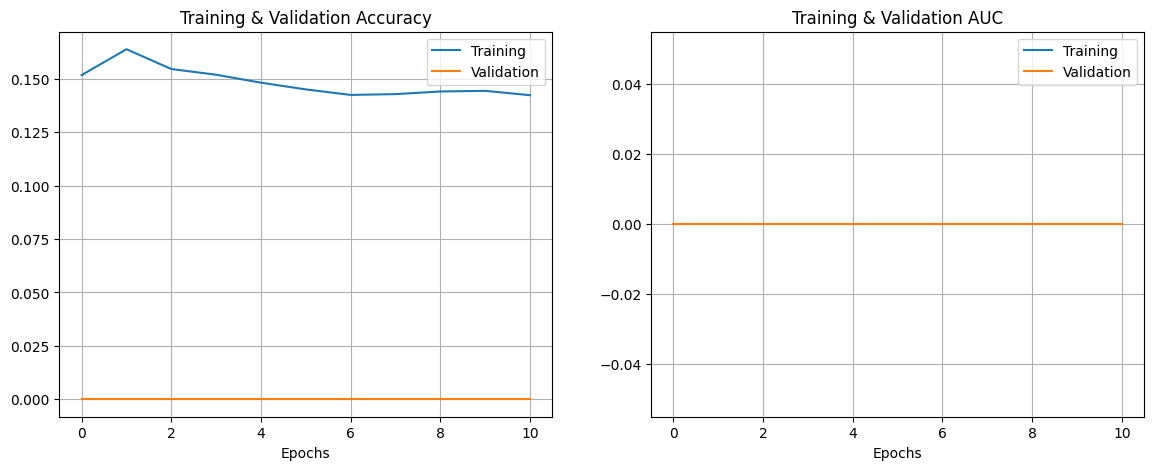

In [77]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(range(len(history2.history["accuracy"])), history2.history["accuracy"], label="Training")
axs[0].plot(range(len(history2.history["val_accuracy"])), history2.history["val_accuracy"], label="Validation")
axs[0].set_xlabel("Epochs")
axs[0].set_title("Training & Validation Accuracy")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(len(history2.history["auc"])), history2.history["auc"], label="Training")
axs[1].plot(range(len(history2.history["val_auc"])), history2.history["val_auc"], label="Validation")
axs[1].set_xlabel("Epochs")
axs[1].set_title("Training & Validation AUC")
axs[1].legend()
axs[1].grid(True)

plt.show()